<a href="https://colab.research.google.com/github/sujithh1110/reinforcement-learning/blob/main/lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Default title text
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random
import time

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, hidden_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)


In [3]:
def discount_rewards(rewards, gamma):
    discounted = []
    R = 0.0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted.append(R)
    discounted.reverse()
    return discounted

def run_episode(env, policy, device, render=False):
    # handle env.reset() returning either obs or (obs, info)
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        obs = reset_result[0]
    else:
        obs = reset_result

    log_probs = []
    rewards = []

    while True:
        obs_v = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        probs = policy(obs_v).squeeze(0)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)

        step_result = env.step(action.item())

        # handle 4-tuple (obs, reward, done, info)
        # and 5-tuple (obs, reward, terminated, truncated, info)
        if len(step_result) == 4:
            obs, reward, done, info = step_result
        else:
            obs, reward, terminated, truncated, info = step_result
            done = terminated or truncated

        log_probs.append(log_prob)
        rewards.append(reward)

        if render:
            try:
                env.render()
            except Exception:
                pass

        if done:
            break

    return log_probs, rewards


In [4]:
def train_reinforce(env_name='CartPole-v1',
                    hidden_size=128,
                    lr=1e-2,
                    gamma=0.99,
                    batch_size=5,
                    max_episodes=1000,
                    seed=0,
                    device=None,
                    render=False):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make(env_name)

    # robust seeding (works across gym versions)
    try:
        env.reset(seed=seed)
    except TypeError:
        try:
            env.seed(seed)
        except Exception:
            pass
    try:
        env.action_space.seed(seed)
    except Exception:
        pass
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy = PolicyNet(obs_dim, hidden_size, n_actions).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    running_rewards = []
    mean_rewards_history = []
    reward_deque = deque(maxlen=100)

    episode = 0
    start_time = time.time()

    while episode < max_episodes:
        batch_log_probs = []
        batch_returns = []
        batch_episode_rewards = []

        for _ in range(batch_size):
            log_probs, rewards = run_episode(env, policy, device, render=render)
            returns = discount_rewards(rewards, gamma)

            # stack log_probs for this episode and make returns tensor
            log_probs_tensor = torch.stack(log_probs)
            returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)

            # normalize returns (avoid division by zero)
            if returns_tensor.size(0) > 1:
                returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

            batch_log_probs.append(log_probs_tensor)
            batch_returns.append(returns_tensor)

            ep_reward = float(sum(rewards))
            batch_episode_rewards.append(ep_reward)
            reward_deque.append(ep_reward)
            running_rewards.append(ep_reward)
            episode += 1

        optimizer.zero_grad()
        # initialize loss as tensor on correct device
        loss = torch.tensor(0.0, dtype=torch.float32, device=device)

        for lp, R in zip(batch_log_probs, batch_returns):
            # (lp * R) multiplies per-timestep; sum over timesteps
            loss = loss + (- (lp * R).sum())

        loss = loss / batch_size
        loss.backward()
        optimizer.step()

        mean_reward = np.mean(batch_episode_rewards)
        mean_last100 = np.mean(reward_deque) if len(reward_deque) > 0 else mean_reward
        mean_rewards_history.append(mean_last100)

        if episode % 10 == 0 or episode == 1:
            print(f"Episode: {episode:4d}\tBatch mean: {mean_reward:.2f}\tLast100 mean: {mean_last100:.2f}\tLoss: {loss.item():.4f}")

        if mean_last100 >= 195.0 and len(reward_deque) == 100:
            print(f"Solved in {episode} episodes! Average reward {mean_last100:.2f} over last 100 episodes.")
            break

    total_time = time.time() - start_time
    print(f"Training finished after {episode} episodes and {total_time:.1f}s")
    try:
        env.close()
    except Exception:
        pass

    return policy, running_rewards, mean_rewards_history



In [5]:
def plot_rewards(running_rewards, mean_rewards_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(running_rewards, alpha=0.6)
    plt.title("Episode rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1,2,2)
    plt.plot(mean_rewards_history)
    plt.title("100-episode moving mean")
    plt.xlabel("Batch")
    plt.tight_layout()
    plt.show()


In [6]:
if __name__ == "__main__":
    policy, running_rewards, mean_hist = train_reinforce(
        env_name='CartPole-v1',
        hidden_size=128,
        lr=1e-2,
        gamma=0.99,
        batch_size=10,    # adjust as needed
        max_episodes=2000,
        seed=42,
        render=False
    )
    plot_rewards(running_rewards, mean_hist)


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


AttributeError: module 'numpy' has no attribute 'bool8'

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
!pip install gymnasium

In [8]:
import gymnasium as gym # Import gymnasium with the alias gym

# The rest of your imports remain the same
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random
import time

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, hidden_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
def discount_rewards(rewards, gamma):
    discounted = []
    R = 0.0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted.append(R)
    discounted.reverse()
    return discounted

def run_episode(env, policy, device, render=False):
    # handle env.reset() returning either obs or (obs, info)
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        obs = reset_result[0]
    else:
        obs = reset_result

    log_probs = []
    rewards = []

    while True:
        obs_v = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        probs = policy(obs_v).squeeze(0)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)

        step_result = env.step(action.item())

        # handle 4-tuple (obs, reward, done, info)
        # and 5-tuple (obs, reward, terminated, truncated, info)
        if len(step_result) == 4:
            obs, reward, done, info = step_result
        else:
            obs, reward, terminated, truncated, info = step_result
            done = terminated or truncated


        log_probs.append(log_prob)
        rewards.append(reward)

        if render:
            try:
                env.render()
            except Exception:
                pass

        if done:
            break

    return log_probs, rewards

In [11]:
def train_reinforce(env_name='CartPole-v1',
                    hidden_size=128,
                    lr=1e-2,
                    gamma=0.99,
                    batch_size=5,
                    max_episodes=1000,
                    seed=0,
                    device=None,
                    render=False):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make(env_name)

    # robust seeding (works across gym versions)
    try:
        env.reset(seed=seed)
    except TypeError:
        try:
            env.seed(seed)
        except Exception:
            pass
    try:
        env.action_space.seed(seed)
    except Exception:
        pass
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)


    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy = PolicyNet(obs_dim, hidden_size, n_actions).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    running_rewards = []
    mean_rewards_history = []
    reward_deque = deque(maxlen=100)

    episode = 0
    start_time = time.time()

    while episode < max_episodes:
        batch_log_probs = []
        batch_returns = []
        batch_episode_rewards = []

        for _ in range(batch_size):
            log_probs, rewards = run_episode(env, policy, device, render=render)
            returns = discount_rewards(rewards, gamma)

            # stack log_probs for this episode and make returns tensor
            log_probs_tensor = torch.stack(log_probs)
            returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)

            # normalize returns (avoid division by zero)
            if returns_tensor.size(0) > 1:
                returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

            batch_log_probs.append(log_probs_tensor)
            batch_returns.append(returns_tensor)

            ep_reward = float(sum(rewards))
            batch_episode_rewards.append(ep_reward)
            reward_deque.append(ep_reward)
            running_rewards.append(ep_reward)
            episode += 1

        optimizer.zero_grad()
        # initialize loss as tensor on correct device
        loss = torch.tensor(0.0, dtype=torch.float32, device=device)

        for lp, R in zip(batch_log_probs, batch_returns):
            # (lp * R) multiplies per-timestep; sum over timesteps
            loss = loss + (- (lp * R).sum())

        loss = loss / batch_size
        loss.backward()
        optimizer.step()

        mean_reward = np.mean(batch_episode_rewards)
        mean_last100 = np.mean(reward_deque) if len(reward_deque) > 0 else mean_reward
        mean_rewards_history.append(mean_last100)


        if episode % 10 == 0 or episode == 1:
            print(f"Episode: {episode:4d}\tBatch mean: {mean_reward:.2f}\tLast100 mean: {mean_last100:.2f}\tLoss: {loss.item():.4f}")

        if mean_last100 >= 195.0 and len(reward_deque) == 100:
            print(f"Solved in {episode} episodes! Average reward {mean_last100:.2f} over last 100 episodes.")
            break


    total_time = time.time() - start_time
    print(f"Training finished after {episode} episodes and {total_time:.1f}s")
    try:
        env.close()
    except Exception:
        pass

    return policy, running_rewards, mean_rewards_history

In [12]:
def plot_rewards(running_rewards, mean_rewards_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(running_rewards, alpha=0.6)
    plt.title("Episode rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1,2,2)
    plt.plot(mean_rewards_history)
    plt.title("100-episode moving mean")
    plt.xlabel("Batch")
    plt.tight_layout()
    plt.show()

Episode:   10	Batch mean: 23.00	Last100 mean: 23.00	Loss: 0.0273
Episode:   20	Batch mean: 32.90	Last100 mean: 27.95	Loss: -0.1826
Episode:   30	Batch mean: 24.80	Last100 mean: 26.90	Loss: -0.0333
Episode:   40	Batch mean: 20.60	Last100 mean: 25.32	Loss: 0.0472
Episode:   50	Batch mean: 19.70	Last100 mean: 24.20	Loss: -0.3498
Episode:   60	Batch mean: 26.20	Last100 mean: 24.53	Loss: -0.1563
Episode:   70	Batch mean: 44.40	Last100 mean: 27.37	Loss: -0.4737
Episode:   80	Batch mean: 60.40	Last100 mean: 31.50	Loss: 0.1794
Episode:   90	Batch mean: 58.60	Last100 mean: 34.51	Loss: 0.4122
Episode:  100	Batch mean: 40.30	Last100 mean: 35.09	Loss: 0.0772
Episode:  110	Batch mean: 52.80	Last100 mean: 38.07	Loss: 0.2238
Episode:  120	Batch mean: 54.00	Last100 mean: 40.18	Loss: -0.6352
Episode:  130	Batch mean: 56.20	Last100 mean: 43.32	Loss: 0.6252
Episode:  140	Batch mean: 60.30	Last100 mean: 47.29	Loss: -0.3158
Episode:  150	Batch mean: 54.90	Last100 mean: 50.81	Loss: -0.2538
Episode:  160	Bat

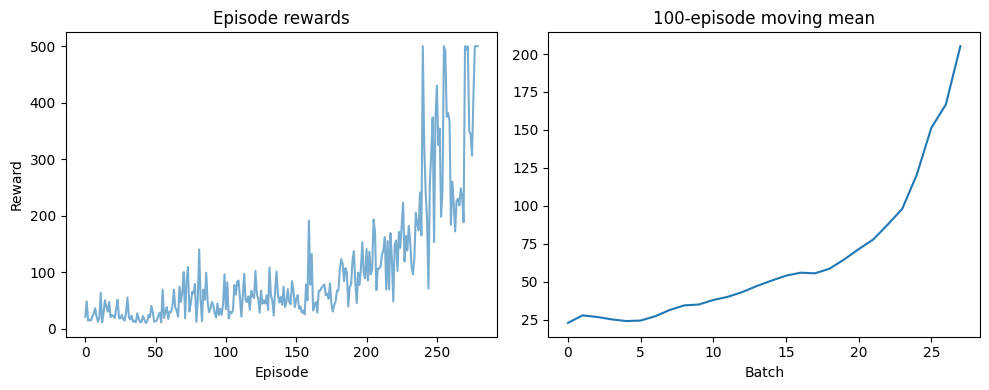

In [13]:
if __name__ == "__main__":
    policy, running_rewards, mean_hist = train_reinforce(
        env_name='CartPole-v1',
        hidden_size=128,
        lr=1e-2,
        gamma=0.99,
        batch_size=10,    # adjust as needed
        max_episodes=2000,
        seed=42,
        render=False
    )
    plot_rewards(running_rewards, mean_hist)

In [14]:
import numpy as np

# Fix for compatibility: map np.bool8 -> np.bool_
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

In [15]:
import numpy as np

# Fix for compatibility: map np.bool8 → np.bool_
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_
